## Tutorial #5: Applying Machine Learning Methods to EEG Data on Group Level

In this tutorial, same classification tasks in Tutorial-4 will be examined but this time analysis will be done on group level.

##### Dataset: 
The the previous tutorial data of the only one participant in 'Emotion-Antecedent Appraisal Checks: EEG and EMG data sets for Novelty and Pleasantness' is used. In this tutorial, all participans will be included

In [16]:
import mne
from os.path import isfile, join
from os import listdir
import numpy as np
from mne.decoding import Vectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from scipy import stats

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [2]:
#Load Dataset
data_folder = '../../study1/study1_eeg/epochdata/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f))]
ids = [int(f[-6:-4]) for f in files]
print(ids)
numberOfEpochs = np.zeros((len(ids), 3))
# Read the EEG epochs:
epochs_all_UN, epochs_all_UP, epochs_all_NP = [], [], []
for f in range(len(files)):
    epochs = mne.read_epochs(files[f], verbose=False)
    epochs_UN = epochs['FU', 'FN']
    epochs_UP = epochs['FU', 'FP']
    epochs_NP = epochs['FN', 'FP']
    numberOfEpochs[f,0] = int(len(epochs_UN.events))
    numberOfEpochs[f,1] = int(len(epochs_UP.events))
    numberOfEpochs[f,2] = int(len(epochs_NP.events))
    UN, UP, NP = [ids[f]], [ids[f]], [ids[f]]
    UN.append(epochs_UN)
    UP.append(epochs_UP)
    NP.append(epochs_NP)
    epochs_all_UN.append(UN)
    epochs_all_UP.append(UP)
    epochs_all_NP.append(NP)

print(numberOfEpochs)
epochs_all_UN = np.array(epochs_all_UN)
epochs_all_UP = np.array(epochs_all_UP)
epochs_all_NP = np.array(epochs_all_NP)


[15, 1, 14, 2, 16, 17, 3, 7, 13, 12, 6, 10, 4, 5, 11, 20, 8, 9, 21, 23, 22, 26, 27, 24, 18]


<ipython-input-2-decee834c9f4>:10: RuntimeWarning: This filename (../../study1/study1_eeg/epochdata/P-15.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(files[f], verbose=False)
<ipython-input-2-decee834c9f4>:10: RuntimeWarning: This filename (../../study1/study1_eeg/epochdata/P-01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(files[f], verbose=False)
<ipython-input-2-decee834c9f4>:10: RuntimeWarning: This filename (../../study1/study1_eeg/epochdata/P-14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(files[f], verbose=False)
<ipython-input-2-decee834c9f4>:10: RuntimeWarning: This filename (../../study1/study1_eeg/epochdata/P-02.fif) does not conform to MNE naming c

[[421. 416. 395.]
 [249. 256. 259.]
 [363. 364. 379.]
 [476. 484. 482.]
 [436. 457. 443.]
 [319. 328. 325.]
 [238. 239. 241.]
 [277. 266. 293.]
 [229. 223. 260.]
 [278. 292. 278.]
 [450. 446. 450.]
 [441. 453. 448.]
 [273. 254. 263.]
 [259. 263. 244.]
 [410. 414. 410.]
 [277. 269. 280.]
 [357. 357. 360.]
 [192. 183. 209.]
 [352. 361. 371.]
 [445. 454. 461.]
 [266. 262. 266.]
 [425. 424. 431.]
 [389. 379. 390.]
 [471. 476. 481.]
 [282. 290. 288.]]


In [3]:
accuracies, f1_scores = [], []

In [15]:
def getData_labels(epochs):
    data, labels, ids = [], [], []
    for p in epochs:
        tmp_epoch = p[1]
        tmp_labels = tmp_epoch.events[:,-1]
        labels.extend(tmp_labels)
        tmp_id = p[0]
        ids.extend([tmp_id]*len(tmp_labels))
        '''
        tmp_data = tmp_epoch.get_data()
        new_data = np.expand_dims(tmp_data, axis=3)
        
        for i in range(len(tmp_data)):
            e = tmp_data[i]
            
            tmp_id_list = [tmp_id]*len(e)
            e = np.expand_dims(e, axis=2)
            for a in range(len(e)):
                for b in range(len(e[a])): e[a][b][0] = tmp_id
            new_data[i] = e
        '''
        
        data.extend(tmp_epoch.get_data())
        
    data = np.array(data)
    labels = np.array(labels)
    ids = np.array(ids)
    return data, labels, ids

### Example #1:  Classification between Unpleasant and Pleasant Events

In [5]:
from sklearn.impute import SimpleImputer
data_UP, labels_UP, ids_UP = getData_labels(epochs_all_UP)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

for d in range(len(data_UP)):
    if np.all(np.isfinite(data_UP[d])) == False:
        print(d)
        data_UP[d] = np.nan_to_num(data_UP[d])
    if np.any(np.isnan(data_UP[d])) == True:
        data_UP[d] = np.nan_to_num(data_UP[d])

data_UP = data_UP.astype('float64')
labels_UP = labels_UP.astype('float64')

5781
True
False


In [19]:
def calculate_score_groupLevel(ids, predictions, labels):
    print(len(predictions))
    print(len(labels))
    unique_ids = list(set(ids))
    results = []
    for id in unique_ids:
        res = 0
        indices = [i for i, x in enumerate(ids) if x == id]
        for i in range(len(indices)):
            if predictions[i] == labels[i]:
                res += 1
        
        results.append(res/len(indices))
    
    accuracy = sum(results)/len(results)
    return accuracy

Create all models and then run cross validation for all of them for comparing their performances.

In [20]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))

models = [clf_lda_pip, clf_lr_pip]
model_names = ['LDA', 'LR'] 

In [ ]:
results = []
for i in range(len(models)):
    print(model_names[i])
    kfold = StratifiedKFold(n_splits=5, random_state=42)
    if np.all(np.isfinite(data_UP)) == True and np.any(np.isnan(data_UP)) == False:
        #cv_res = cross_val_score(models[i], data_UP, labels_UP, cv=kfold, scoring='accuracy')
        pedictions_UP = cross_val_predict(models[i], data_UP, labels_UP, cv=kfold)
        cv_accuracy = calculate_score_groupLevel(ids, pedictions_UP, labels_UP)
        results.append(cv_accuracy)
        msg = "m%s: %f (%f)" % (model_names[i], cv_accuracy.mean(), cv_accuracy.std())
        print(msg)
    else:
        print('Data has infinite or NaN value!')    

LDA


/anaconda3/envs/pinar/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/anaconda3/envs/pinar/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/anaconda3/envs/pinar/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/anaconda3/envs/pinar/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/anaconda3/envs/pinar/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analy

Below boxplot visualizes the distibutions of corssvalidation results for LDA and LR models.

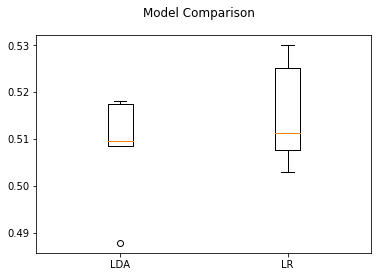

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(model_names)
plt.show()

Independent t-test is applied to statistically show whether there is a significant difference between performace of two models. Small p-value means that performace of models are significantly different, large p-value indicates that models are performing similar. In general, as the threshold for determining whether two distributions are different or not p = 0.05 is preffered.

In [14]:
t, p = stats.ttest_ind(results[0],results[1])
print("p = " + str(p))

p = 0.3745601608525917


Since p-value is larger than 0.05, we can conclude that there is no significant difference between performance of LDA and performance of LR on the task of classification between unpleasant and pleasant events.

### Example #2:  Classification between Unpleasant and Pleasant Events

In [135]:
# Dataset with unpleasant and neutral events
data_UP, labels_UP = getData_labels(epochs_all_UP)
print(data_UP.shape)
print(labels_UP.shape)

(8610, 64, 384)
(8610,)


In [136]:
train_data_UP, test_data_UP, labels_train_UP, labels_test_UP = train_test_split(data_UP, labels_UP, test_size=0.3, random_state=42)
print(train_data_UP.shape)
print(test_data_UP.shape)

(6027, 64, 384)
(2583, 64, 384)


In [137]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
clf_lda_pip.fit(train_data_UP,labels_train_UP)

predictions_lda = clf_lda_pip.predict(test_data_UP)

acc_lda = accuracy_score(labels_test_UP, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test_UP,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy of LDA model: 0.5257452574525745
Precision: 0.5258076314274751, Recall: 0.5258103241296519, f1-score:0.525742698467727


In [138]:
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))
clf_lr_pip.fit(train_data_UP,labels_train_UP)

predictions_lr = clf_lr_pip.predict(test_data_UP)

acc_lr = accuracy_score(labels_test_UP, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lra=precision_recall_fscore_support(labels_test_UP,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of LR model: 0.5663956639566395
Precision: 0.5664200768367436, Recall: 0.566431467691972, f1-score:0.5663846804122474


In [139]:
accuracies.append([acc_lda, acc_lr])
f1_scores.append([fscore_lda, fscore_lr])

### Example #3: Classification between Pleasant and Neutral Events

In [140]:
# Dataset with unpleasant and neutral events
data_NP, labels_NP = getData_labels(epochs_all_NP)
print(data_NP.shape)
print(labels_NP.shape)

(8707, 64, 384)
(8707,)


In [141]:
train_data_NP, test_data_NP, labels_train_NP, labels_test_NP = train_test_split(data_NP, labels_NP, test_size=0.3, random_state=42)
print(train_data_NP.shape)
print(test_data_NP.shape)

(6094, 64, 384)
(2613, 64, 384)


In [142]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
clf_lda_pip.fit(train_data_NP,labels_train_NP)

predictions_lda = clf_lda_pip.predict(test_data_NP)

acc_lda = accuracy_score(labels_test_NP, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test_NP,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy of LDA model: 0.5208572522005358
Precision: 0.5208719780921569, Recall: 0.5208702172906914, f1-score:0.5208515679099572


In [143]:
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))
clf_lr_pip.fit(train_data_NP,labels_train_NP)

predictions_lr = clf_lr_pip.predict(test_data_NP)

acc_lr = accuracy_score(labels_test_NP, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test_NP,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of LR model: 0.53769613471106
Precision: 0.5376946465605118, Recall: 0.5376948673935076, f1-score:0.5376944419708765


In [144]:
accuracies.append([acc_lda, acc_lr])
f1_scores.append([fscore_lda, fscore_lr])

In [145]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [231]:
def plotEvalMetrics(tasks, labels, evalMetric, metricName):
    width = 0.2  # the width of the bars

    # Set position of bar on X axis
    rects1 = np.arange(len(evalMetric))
    rects2 = [x + width for x in rects1]
    rects3 = [x + width for x in rects2]

    plt.bar(rects1, list(zip(*evalMetric))[0], color='#87CEFA', width=width, edgecolor='white', label=labels[0])
    plt.bar(rects2, list(zip(*evalMetric))[1], color='#FFE4E1', width=width, edgecolor='white', label=labels[1])
    
    plt.xlabel('Classification Tasks')
    plt.xticks([r + width/2 for r in range(len(evalMetric))], tasks)
    plt.ylabel(metricName)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', )
    plt.show()

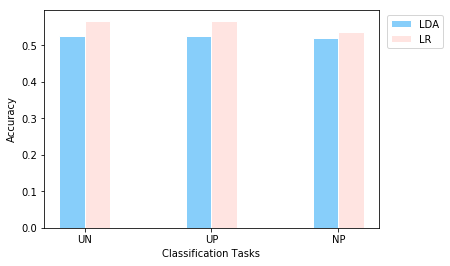

In [233]:
#Plot Accuracies
tasks = ['UN', 'UP', 'NP']
labels = ['LDA', 'LR']
plotEvalMetrics(tasks, labels, accuracies, 'Accuracy')

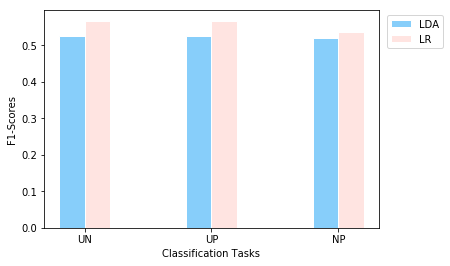

In [234]:
#Plot F1 Scores
tasks = ['UN', 'UP', 'NP']
labels = ['LDA', 'LR']
plotEvalMetrics(tasks, labels, f1_scores, 'F1-Scores')

As part of group level analysis of eeg data, logistic regression (lr) and linear discriminant analysis (lda) are created as in the previous tutorial but this time svm is omitted because it requires hours to build with the amount of data we have. 

As both accuracy and f1 score plots demonstrated, logistic regression is performing better than lda on all tasks unlike the previous tutorial in which we analyze the data on individual participant level.